<a href="https://colab.research.google.com/github/iamchenchu/Deep-Learnig-with-TensorFlow/blob/main/07_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part : 3   Scaling Up (Food vision mini)

we've see the power of transfer learning feature extraction and fine tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food)

Our goal is to beat the origin Food101 paper with 10% of the training data, leveraging the power of deep learning.

Original Food101 paper :  https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [2]:
#Check to see if we've using a GPU
!nvidia-smi

Fri Dec 22 22:09:52 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
## Creating helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

#Import all the functions from the helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

--2023-12-22 22:19:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-22 22:19:23 (119 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 101 Food Classes : working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

THe data we downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb


In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2023-12-22 22:27:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.174.207, 74.125.23.207, 64.233.187.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.174.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  24.8MB/s    in 62s     

2023-12-22 22:28:47 (24.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
#How many images/classes are there

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/filet_mignon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_and_sour_soup'.
There are 0 directories and 75 images i

In [15]:
#setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)

test_data= tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                               label_mode = "categorical",
                                                                               image_size = IMG_SIZE,
                                                                               shuffle = False) #don't shuffle the test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right inti the model
* Build a headless (No top layers) Functiona EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [8]:
# Create a checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)


In [11]:
# Create a data augmentation layer to build data augmentation right into our model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name = "data_augmentation")




In [12]:
# Setup a base model and freeze it's layers (this will extract features) Build a headless (no top layers)

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#Setup model architecture with trainable top layers
inputs = layers.Input(shape = (224, 224, 3), name = "input_layer")
x = data_augmentation(inputs) # Augment images (only happens during training phase)
x = base_model(x, training = False) # put the base model in inference mode so weights which need to stay frozen will stay frozen
x = layers.GlobalAveragePooling2D(name = "global_avg_pool_layer")(x)

outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [13]:
#Get the summary for the model we created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [16]:
#compile our model

model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

#Fit the model

history_all_data_classes_10_percent= model.fit(train_data_all_10_percent,
                                              epochs = 5,
                                              validation_data = test_data,
                                              validation_steps = int(0.15 * len(test_data)),
                                              callbacks = [checkpoint_callback])


Epoch 1/5
237/237 [==============================] - 144s 569ms/step - loss: 3.3652 - accuracy: 0.2710 - val_loss: 2.5060 - val_accuracy: 0.4391
Epoch 2/5
237/237 [==============================] - 96s 403ms/step - loss: 2.1888 - accuracy: 0.4958 - val_loss: 2.0553 - val_accuracy: 0.5103
Epoch 3/5
237/237 [==============================] - 87s 365ms/step - loss: 1.8202 - accuracy: 0.5704 - val_loss: 1.8939 - val_accuracy: 0.5238
Epoch 4/5
237/237 [==============================] - 73s 309ms/step - loss: 1.6048 - accuracy: 0.6127 - val_loss: 1.8107 - val_accuracy: 0.5315
Epoch 5/5
237/237 [==============================] - 68s 284ms/step - loss: 1.4467 - accuracy: 0.6446 - val_loss: 1.7935 - val_accuracy: 0.5302


In [17]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 48s 61ms/step - loss: 1.6100 - accuracy: 0.5758


[1.6100093126296997, 0.5757623910903931]

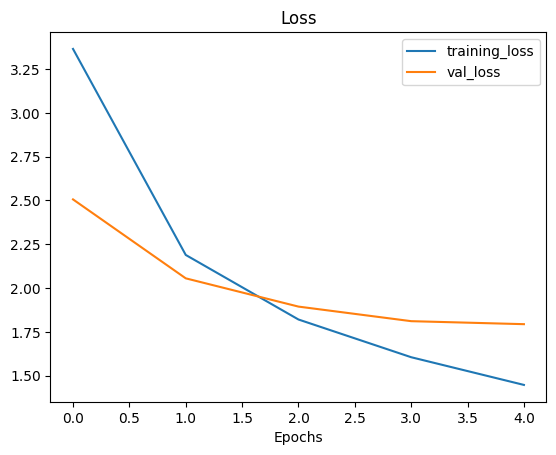

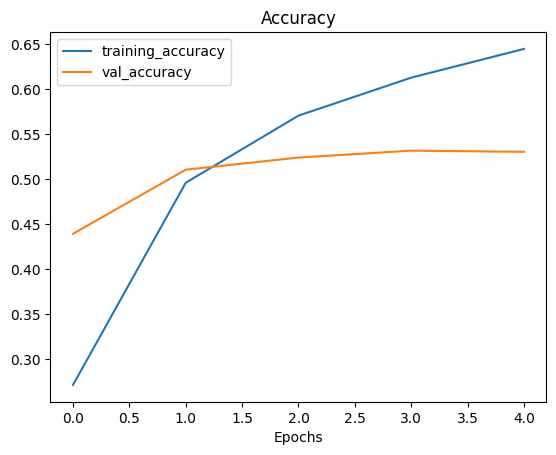

In [18]:
plot_loss_curves(history_all_data_classes_10_percent)